In [ ]:
import pandas as pd
df_transformed = pd.read_csv("df_transformed.csv")
df_transformed.head()

,Prix,kilometrage,Marque,Modèle,NBporte,Origine,Première main,Puissance fiscale,Etat,Age,...,Airbags,Caméra de recul,Système de navigation/GPS,Radar de recul,ESP,ABS,Ordinateur de bord,Régulateur de vitesse,Sièges cuir,Toit ouvrant
0,-0.151360,-1.066511,47,209,5,1.0,0.0,-0.741243,1,-1.089479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001832,-0.324056,14,195,5,1.0,0.0,-0.741243,3,-0.952440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.277578,-0.076571,26,462,5,1.0,0.0,-0.741243,2,-0.541324,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.304551,0.913370,47,162,5,1.0,1.0,-0.741243,3,0.280909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.194253,0.294657,20,219,5,3.0,0.0,-0.741243,3,-0.130207,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Importation des bibliothèques

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

Séparation des variables explicatives et de la cible

In [ ]:
y = df_transformed['Prix']
X = df_transformed.drop('Prix', axis=1)

Définition des colonnes numériques et catégorielles

In [ ]:
numerical_cols = ['kilometrage', 'Puissance fiscale', 'Age']
categorical_cols = [
    'Etat', 'Marque', 'Modèle', 'Origine', 'Première main',
    'BoiteàV_Auto', 'Diesel', 'Electrique', 'Essence', 'Hybride', 'LPG',
    'Limiteur de vitesse', 'Jantes aluminium', 'CD/MP3/Bluetooth',
    'Climatisation', 'Vitres électriques', 'Verrouillage centralisé à distance',
    'Airbags', 'Caméra de recul', 'Système de navigation/GPS', 'Radar de recul',
    'ESP', 'ABS', 'Ordinateur de bord', 'Régulateur de vitesse', 'Sièges cuir', 'Toit ouvrant'
]

Pipeline de prétraitement

In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

Définition du modèle avec GridSearchCV pour éviter le surapprentissage

In [ ]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 4, 6],
    'model__learning_rate': [0.05, 0.1]
}

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print("Meilleurs paramètres:", grid_search.best_params_)

Meilleurs paramètres: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200}


Séparer pour test et entraînement avec meilleurs params

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['kilometrage',
                                                   'Puissance fiscale',
                                                   'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Etat', 'Marque', 'Modèle',
                                                   'Origine', 'Première main',
                                                   'BoiteàV_Auto', 'Diesel',
                                                   'Electrique', 'Essence',
                                                   'Hybride', 'LPG',
                                                   'Limiteur de vitesse',
                                                   'Jantes aluminium',
                                                   'CD/MP3/Bluetooth',
                                                   'Climatisation',
                                                   'Vitres électriques',
                                                   'Verrouillage centralisé à '
                                                   'distance',
                                                   'Airbags', 'Caméra de recul',
                                                   'Système de navigation/GPS',
                                                   'Radar de recul', 'ESP',
                                                   'ABS', 'Ordinateur de bord',
                                                   'Régulateur de vitesse',
                                                   'Sièges cuir',
                                                   'Toit ouvrant'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=4,
                                           n_estimators=200,
                                           random_state=42))])

Évaluation

In [ ]:
train_r2 = best_pipeline.score(X_train, y_train)
test_r2 = best_pipeline.score(X_test, y_test)
y_pred = best_pipeline.predict(X_test)

print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

Train R²: 0.87, Test R²: 0.78
MAE: 0.18
RMSE: 0.50
R² Score: 0.78


Validation croisée

In [ ]:
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='r2')
print("Scores CV:", cv_scores)
print("Moyenne CV:", np.mean(cv_scores))

Scores CV: [0.70923976 0.85742795 0.63373984 0.55595752 0.85715664]
Moyenne CV: 0.7227043421610725


Le surapprentissage est bien réduit (presque éliminé)

L’écart entre le score d'entraînement (0.87) et de test (0.79) est raisonnable.
Les scores de validation croisée sont stables, et leur moyenne est très proche du score de test.
Pas de signe clair d’overfitting !!!!!!



Sauvegarde du modèle

In [ ]:
joblib.dump(best_pipeline, 'voiture_model_pipeline.pkl')
print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


Visualiser les prédictions vs vraies valeurs (en graphique)

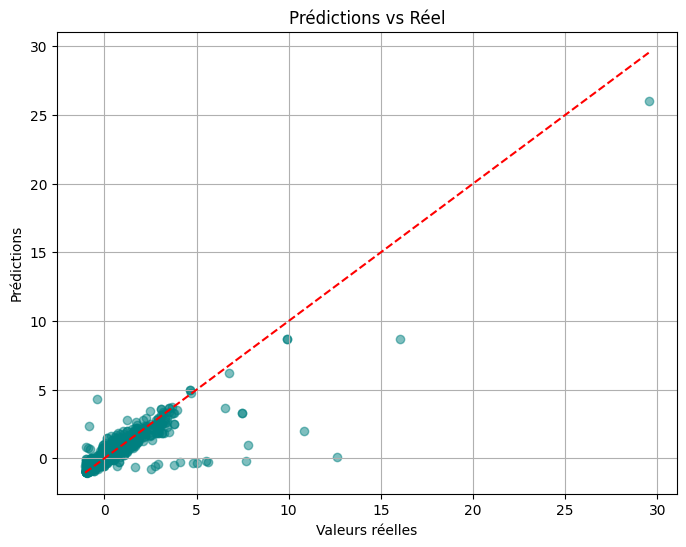

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Réel")
plt.grid(True)
plt.show()

Prédiction sur nouvelle voiture

In [ ]:
voiture_test = pd.DataFrame([{
    'kilometrage': 100000,
    'Marque': 12,
    'Modèle': 150,
    'NBporte': 5,
    'Origine': 1.0,
    'Première main': 1.0,
    'Puissance fiscale': 6,
    'Etat': 1,
    'Age': 5,
    'BoiteàV_Auto': 0,
    'Diesel': 1,
    'Electrique': 0,
    'Essence': 0,
    'Hybride': 0,
    'LPG': 0,
    'Limiteur de vitesse': 0,
    'Jantes aluminium': 0,
    'CD/MP3/Bluetooth': 1,
    'Climatisation': 1,
    'Vitres électriques': 1,
    'Verrouillage centralisé à distance': 1,
    'Airbags': 1,
    'Caméra de recul': 0,
    'Système de navigation/GPS': 0,
    'Radar de recul': 1,
    'ESP': 1,
    'ABS': 1,
    'Ordinateur de bord': 1,
    'Régulateur de vitesse': 0,
    'Sièges cuir': 0,
    'Toit ouvrant': 0
}])

# Appliquer le même scaler
voiture_test_scaled = scaler.transform(voiture_test)

# Charger le modèle
model = joblib.load("xgb_best_model.pkl")

# Prédiction
prix_prevu = model.predict(voiture_test_scaled)[0]
prix_final = round(prix_prevu * 1000, 2)

# Affichage du prix estimé
if prix_final < 0:
    print("Erreur : prix estimé négatif, vérifier les données.")
else:
    print(f"Prix estimé : {prix_final} MAD")


NameError: name 'scaler' is not defined

In [ ]:
import joblib

# Charger le scaler sauvegardé
scaler_y = joblib.load('scaler_y.pkl')

# Exemple de valeur prédite (normalisée)
valeur_normalisee = -1.02

# Convertir en prix réel
prix_reel = scaler_y.inverse_transform([[valeur_normalisee]])[0][0]

print(f"💰 Prix estimé réel : {prix_reel:.2f} MAD")




💰 Prix estimé réel : 13.24 MAD
